In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import mvsdk
import cv2
from huateng_camera_v2_tc_raw import Camera
from correction_utils import linear_to_srgb

## 1. Perform whole correction.

In [59]:
# Set working directory and Camera params.
EXPOSURE_TIME = 10 # ms
BLC = 32
MAX_ADC_LEVEL = 4096-1
XYZ_TO_SRGB = np.array([[ 3.2404542, -1.5371385, -0.4985314],
                        [-0.9692660,  1.8760108,  0.0415560],
                        [ 0.0556434, -0.2040259,  1.0572252]])
CLIP_ROI = np.array([[1100, 700, 410, 600]]) # x, y, w, h
correction_params = np.load('correction_results_D65_250731.npy', allow_pickle=True).item()
output_folder = r'./visualize_output'
# Create dir if not exist
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

In [57]:
# Grab a raw frame, unpack and save as 16bit tiff.
%matplotlib qt
DevList = mvsdk.CameraEnumerateDevice()
mycam = Camera(DevList[0], EXPOSURE_TIME, gain=1, hibitdepth=1)
mycam.open()
img_raw = mycam.grab_raw()
mycam.close()

# Save img as tiff using matplotlib
plt.imsave(os.path.join(output_folder, '1_Raw.tiff'), img_raw, cmap = 'grey')
plt.imshow(img_raw)

Camera.open: Camera supports 2 pixel format(s)
Camera.open: Pixel format 0: Bayer BG 8bit (1Bpp)
Camera.open: Pixel format 1: Bayer BG 12bit Packed (1.5Bpp)
Camera.open: Using 12bit pixel format.
Camera.open: Timecode disabled. Allocating original image buffer size: 30081024 bytes.
Camera.open: Raw start bit = -1


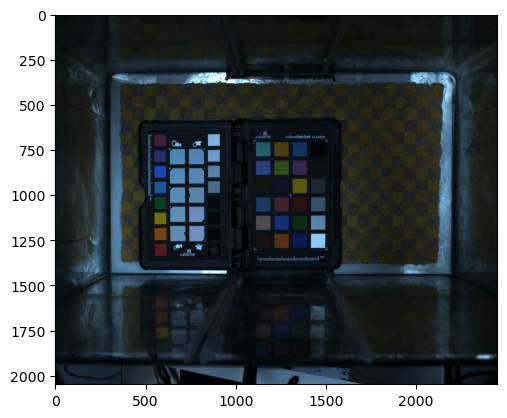

In [ ]:
# Get debayered image in device RGB and save in output folder
%matplotlib inline
img_raw_8 = ((img_raw - 32) / 16).astype(np.uint8) # for VNG debayer method
img_BLC_debayered = np.clip(cv2.cvtColor(img_raw - 32, cv2.COLOR_BAYER_BGGR2RGB).astype(np.uint16),
                             0, MAX_ADC_LEVEL-BLC) # 换换不同的debayer方法?
plt.imshow(img_BLC_debayered / (MAX_ADC_LEVEL-BLC))
plt.imsave(os.path.join(output_folder, '2_BLC_Debayered.tiff'), img_BLC_debayered / (MAX_ADC_LEVEL-BLC))

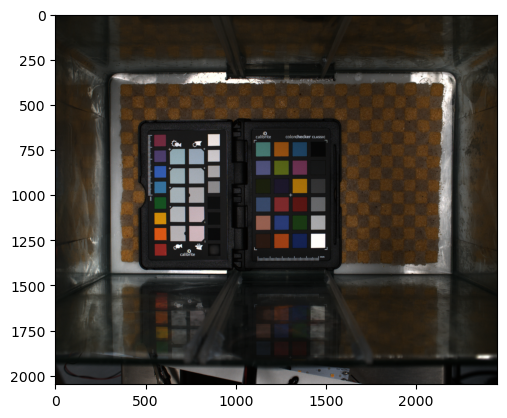

In [54]:
# Debayer + WB
img_BLC_debayered_WB = np.clip((img_BLC_debayered - correction_params['wb_params'][3:]) * correction_params['wb_params'][:3], 
                               0, MAX_ADC_LEVEL-BLC) / (MAX_ADC_LEVEL-BLC)
plt.imshow(img_BLC_debayered_WB)
plt.imsave(os.path.join(output_folder, '3_BLC_Debayered_WB.tiff'), img_BLC_debayered_WB)


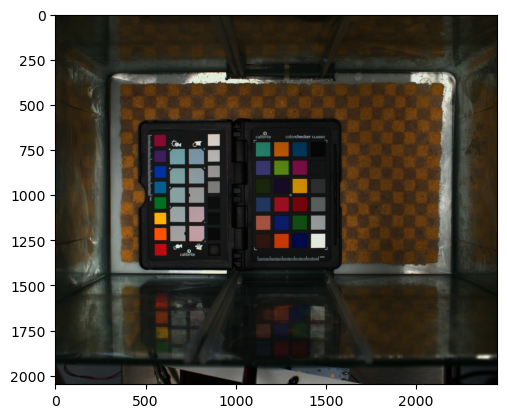

In [55]:
# Debayer + WB + Fwd Mtx + Render Mtx
img_BLC_debayered_WB_Fwd_render = np.clip(img_BLC_debayered_WB @ correction_params['fwd_mtx'].T @ XYZ_TO_SRGB.T, 
                                          0, 1)
plt.imshow(img_BLC_debayered_WB_Fwd_render)
plt.imsave(os.path.join(output_folder, '4_BLC_Debayered_WB_Fwd_render.tiff'), img_BLC_debayered_WB_Fwd_render)


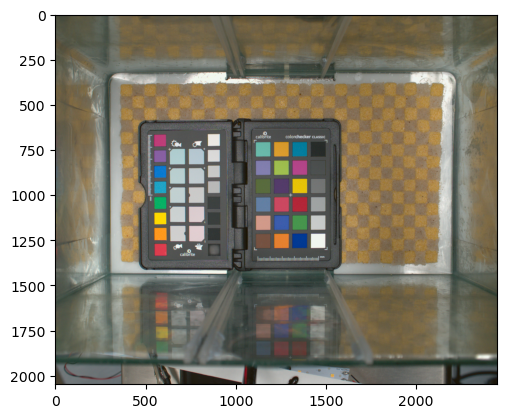

In [56]:
# All (Gamma)
img_BLC_debayered_WB_Fwd_render_gammasRGB = linear_to_srgb(img_BLC_debayered_WB_Fwd_render)
plt.imshow(img_BLC_debayered_WB_Fwd_render_gammasRGB)
plt.imsave(os.path.join(output_folder, '5_BLC_Debayered_WB_Fwd_render_gammasRGB.tiff'), img_BLC_debayered_WB_Fwd_render_gammasRGB)

## 2. Clip to ROI and save

In [ ]:
# Clip and save
if not os.path.exists(os.path.join(output_folder, 'clip')):
    os.makedirs(os.path.join(output_folder, 'clip'))

img_raw_clip = img_raw[CLIP_ROI[0, 1]:CLIP_ROI[0, 1]+CLIP_ROI[0, 3], CLIP_ROI[0, 0]:CLIP_ROI[0, 0]+CLIP_ROI[0, 2]]
plt.imsave(os.path.join(output_folder, 'clip', '1_Raw.tiff'), img_raw_clip, cmap = 'grey')

img_BLC_debayered_clip = img_BLC_debayered[CLIP_ROI[0, 1]:CLIP_ROI[0, 1]+CLIP_ROI[0, 3], CLIP_ROI[0, 0]:CLIP_ROI[0, 0]+CLIP_ROI[0, 2]]
plt.imsave(os.path.join(output_folder, 'clip', '2_BLC_Debayered.tiff'), img_BLC_debayered_clip / (MAX_ADC_LEVEL-BLC))

img_BLC_debayered_WB_clip = img_BLC_debayered_WB[CLIP_ROI[0, 1]:CLIP_ROI[0, 1]+CLIP_ROI[0, 3], CLIP_ROI[0, 0]:CLIP_ROI[0, 0]+CLIP_ROI[0, 2]]
plt.imsave(os.path.join(output_folder, 'clip', '3_BLC_Debayered_WB.tiff'), img_BLC_debayered_WB_clip)

img_BLC_debayered_WB_Fwd_render_clip = img_BLC_debayered_WB_Fwd_render[CLIP_ROI[0, 1]:CLIP_ROI[0, 1]+CLIP_ROI[0, 3], CLIP_ROI[0, 0]:CLIP_ROI[0, 0]+CLIP_ROI[0, 2]]
plt.imsave(os.path.join(output_folder, 'clip', '4_BLC_Debayered_WB_Fwd_Render.tiff'), img_BLC_debayered_WB_Fwd_render_clip)

img_BLC_debayered_WB_Fwd_render_gammasRGB_clip = img_BLC_debayered_WB_Fwd_render_gammasRGB[CLIP_ROI[0, 1]:CLIP_ROI[0, 1]+CLIP_ROI[0, 3], CLIP_ROI[0, 0]:CLIP_ROI[0, 0]+CLIP_ROI[0, 2]]
plt.imsave(os.path.join(output_folder, 'clip', '5_BLC_Debayered_WB_Fwd_Render_Gamma.tiff'), img_BLC_debayered_WB_Fwd_render_gammasRGB_clip)


## 3. Calculate dE of inaccurate implementation

In [87]:
# Calculate inaccurate implementation dE
# Load image(assume sRGB)
import colour

img_inaccurate_path = r'./preview/huatengV3.jpg'
img_inaccurate = plt.imread(img_inaccurate_path)
plt.imshow(img_inaccurate)

In [88]:
# Define chart corners
chart_corners = np.array([
    [1130, 710],
    [1520, 710],
    [1130, 1285],
    [1520, 1285]
])

In [89]:
# Extract 24 patches using correction_utils

from correction_utils import calculate_warped_bboxes, extract_colors_warped_bbox, draw_warped_bboxes
# 1. Calculate the warped bboxes on the original image
# Since orientation is now locked to landscape, we use 4 rows and 6 columns.
warped_bboxes = calculate_warped_bboxes(chart_corners, rows=4, cols=6, margin_percent=0.2)

# 2. Extract mean colors directly from the original image `img`
device_rgb_values_sample = extract_colors_warped_bbox(img_inaccurate, warped_bboxes) / 255

# 3. Visualize the bboxes
# Draw the warped bboxes on the original, uncorrected image
img_with_warped_bboxes = draw_warped_bboxes(img_inaccurate, warped_bboxes)

# 4. Print the values
for i, rgb in enumerate(device_rgb_values_sample):
    rgb_255 = tuple(f'{c * 255:.2f}' for c in rgb)
    print(f"Patch {i+1:2d}: Mean RGB = {rgb_255}")


plt.figure(figsize=(10, 8))
plt.imshow(img_with_warped_bboxes)
plt.title("Warped BBoxes on Original Image")
plt.axis('off')
plt.show()

Patch  1: Mean RGB = ('141.45', '109.59', '88.59')
Patch  2: Mean RGB = ('208.90', '173.33', '160.23')
Patch  3: Mean RGB = ('139.00', '153.03', '185.08')
Patch  4: Mean RGB = ('119.76', '134.33', '82.69')
Patch  5: Mean RGB = ('159.76', '151.78', '192.98')
Patch  6: Mean RGB = ('147.17', '190.92', '178.03')
Patch  7: Mean RGB = ('219.28', '157.68', '73.31')
Patch  8: Mean RGB = ('112.31', '124.98', '196.63')
Patch  9: Mean RGB = ('204.64', '113.37', '124.17')
Patch 10: Mean RGB = ('113.40', '82.48', '139.08')
Patch 11: Mean RGB = ('178.29', '199.88', '107.92')
Patch 12: Mean RGB = ('210.80', '174.33', '73.46')
Patch 13: Mean RGB = ('64.07', '87.34', '179.75')
Patch 14: Mean RGB = ('116.17', '171.44', '101.59')
Patch 15: Mean RGB = ('187.24', '81.27', '73.83')
Patch 16: Mean RGB = ('220.95', '203.73', '68.94')
Patch 17: Mean RGB = ('187.55', '105.88', '163.40')
Patch 18: Mean RGB = ('92.52', '152.47', '180.60')
Patch 19: Mean RGB = ('233.99', '230.52', '227.90')
Patch 20: Mean RGB = ('

In [86]:
# Loading ColorChecker24 Lab_D50 value from X-rite data(after 2015)
import numpy as np

def parse_data_file(file_path):
    # Deepseek
    # 初始化存储变量
    string_list = []
    numeric_data = []
    
    # 标志是否开始/结束读取数据
    reading_data = False
    
    with open(file_path, 'r') as file:
        for line in file:
            line = line.strip()  # 去除首尾空白字符
            
            if not reading_data:
                if line == 'BEGIN_DATA':
                    reading_data = True
                continue
            else:
                if line == 'END_DATA':
                    break
                
                # 分割数据行
                parts = line.split('\t')
                if len(parts) != 4:
                    continue  # 跳过格式不正确的行
                
                # 解析数据
                string_part = parts[0]
                try:
                    numeric_parts = [float(x) for x in parts[1:4]]
                except ValueError:
                    continue  # 跳过数值转换失败的行
                
                # 存储数据
                string_list.append(string_part)
                numeric_data.append(numeric_parts)
    
    # 将数值数据转换为N×3的NumPy数组
    numeric_array = np.array(numeric_data)
    
    return string_list, numeric_array

patch_name, lab_values = parse_data_file('RefPatches.txt')
# The value is column first, where A* is the first column.
patch_name_row_first = np.array(patch_name).reshape(4, 6, order='F').ravel(order='C')
lab_values_row_first = lab_values.reshape((4, 6, 3), order='F').reshape((-1, 3), order='C')
# print(patch_name_row_first)
# print(lab_values_row_first)


In [90]:
# Transform to XYZ
device_xyz_values_sample = colour.sRGB_to_XYZ(device_rgb_values_sample)
dE00_inaccurate = colour.delta_E(lab_values_row_first, 
                      colour.XYZ_to_Lab(device_xyz_values_sample, 
                                        illuminant=colour.CCS_ILLUMINANTS['CIE 1931 2 Degree Standard Observer']['D65']
                                        )
                     )
print(f'dE00 inaccurate: \n{dE00_inaccurate.reshape(4,6)}')
print(f'  dE max: {np.max(dE00_inaccurate):.2f}, min: {np.min(dE00_inaccurate):.2f}, avg: {np.mean(dE00_inaccurate):.2f}')


dE00 inaccurate: 
[[ 11.49881409   9.16398549  14.79573792  10.35641133   9.54011509
    8.24235671]
 [ 12.96205239  15.297291     8.72603756   9.02800506   6.11216585
    9.83455615]
 [  9.94266254   9.80646993   6.27122335   7.90629835   6.44276849
   13.54575675]
 [  3.50613127   1.22992036   4.4288918    7.7030867    7.39699385
    1.09926412]]
  dE max: 15.30, min: 1.10, avg: 8.53
